In [ ]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)


f:\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG
from src2.sampling import (
    sample_domain_points,
    sample_boundary_points,
    sample_interface_points
)
from src2.losses import total_loss
from src2.pde_residuals import *
from src2.boundary_conditions import *


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
net1, net2, net3 = get_all_networks()
net1.to(DEVICE)
net2.to(DEVICE)
net3.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]
p1 = CONFIG["FGPM"]
p2 = CONFIG["HYDROGEL"]
p3 = CONFIG["SUBSTRATE"]


# Optimizer

In [6]:
optimizer = optim.Adam(
    list(net1.parameters()) +
    list(net2.parameters()) +
    list(net3.parameters()),
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [8]:
for epoch in range(1, 200):

    xyt1, xyt2, xyt3 = sample_domain_points(3000, geom)
    xt_top = sample_boundary_points(1000, geom)
    xyt_i1, xyt_i2 = sample_interface_points(1000, geom)

    optimizer.zero_grad()

    loss, logs = total_loss(
        net1, net2, net3,
        xyt1, xyt2, xyt3,
        xt_top,
        xyt_i1,
        xyt_i2,
        p1, p2, p3,
        electrically_open=True
    )

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch} | "
            f"Loss={loss.item():.3e} | "
            f"PDE={logs['pde']:.2e} | "
            f"BC={logs['bc_top']:.2e}"
        )


Epoch 50 | Loss=1.309e+32 | PDE=1.31e+32 | BC=1.53e+13
Epoch 100 | Loss=1.309e+32 | PDE=1.31e+32 | BC=1.55e+11
Epoch 150 | Loss=1.309e+32 | PDE=1.31e+32 | BC=7.28e+10


In [10]:
import torch

torch.save({
    "net1": net1.state_dict(),
    "net2": net2.state_dict(),
    "net3": net3.state_dict()
}, "three_layer_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [11]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

h1 = geom["h1"]
h2 = geom["h2"]
h3 = geom["h3"]

y0 = 0.0
t0 = 0.2


Create a point in each layer

In [12]:
x_fgpm = torch.linspace(-h1, 0, 200).reshape(-1,1)
x_hydro = torch.linspace(0, h2, 200).reshape(-1,1)
x_sub = torch.linspace(h2, h3, 200).reshape(-1,1)

y_fgpm = torch.full_like(x_fgpm, y0)
t_fgpm = torch.full_like(x_fgpm, t0)

y_hydro = torch.full_like(x_hydro, y0)
t_hydro = torch.full_like(x_hydro, t0)

y_sub = torch.full_like(x_sub, y0)
t_sub = torch.full_like(x_sub, t0)


Feed to model

In [13]:
with torch.no_grad():
    w1, phi1 = net1(torch.cat([x_fgpm,y_fgpm,t_fgpm],dim=1).to(DEVICE)).split(1,1)
    w2, phi2 = net2(torch.cat([x_hydro,y_hydro,t_hydro],dim=1).to(DEVICE)).split(1,1)
    w3, phi3 = net3(torch.cat([x_sub,y_sub,t_sub],dim=1).to(DEVICE)).split(1,1)


Plot Displacement & Electrical Potential

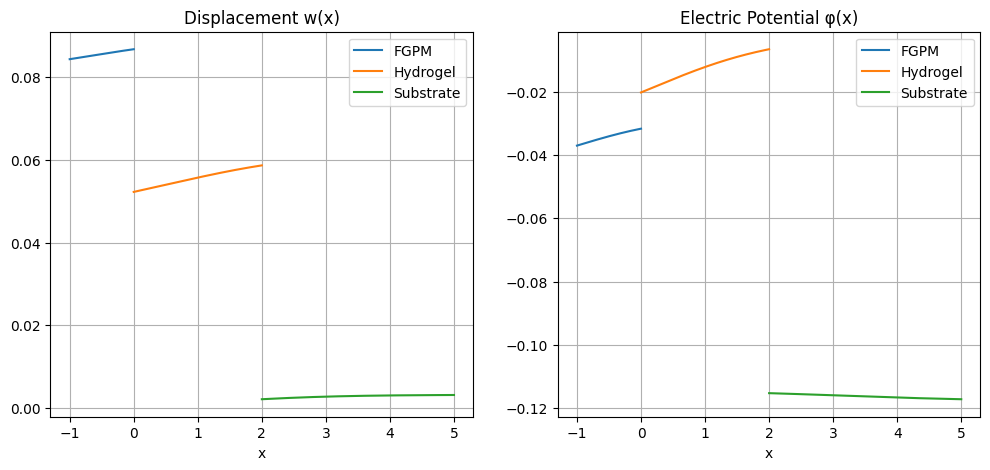

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(x_fgpm.cpu(), w1.cpu(), label="FGPM")
plt.plot(x_hydro.cpu(), w2.cpu(), label="Hydrogel")
plt.plot(x_sub.cpu(), w3.cpu(), label="Substrate")
plt.title("Displacement w(x)")
plt.xlabel("x")
plt.grid(); plt.legend()

plt.subplot(1,2,2)
plt.plot(x_fgpm.cpu(), phi1.cpu(), label="FGPM")
plt.plot(x_hydro.cpu(), phi2.cpu(), label="Hydrogel")
plt.plot(x_sub.cpu(), phi3.cpu(), label="Substrate")
plt.title("Electric Potential φ(x)")
plt.xlabel("x")
plt.grid(); plt.legend()

plt.show()


Verify Interface & Boundary Conditions
✔ At FGPM–Hydrogel interface 
𝑥
=
0
x=0

In [15]:
x0 = torch.tensor([[0., y0, t0]]).to(DEVICE)

w1_0, phi1_0 = net1(x0).split(1,1)
w2_0, phi2_0 = net2(x0).split(1,1)

print("Jump in w:", (w1_0-w2_0).item())
print("Jump in φ:", (phi1_0-phi2_0).item())


Jump in w: 0.034481946378946304
Jump in φ: -0.011461250483989716


# At Hydrogel–Substrate 
𝑥
=
ℎ
2
x=h2

In [16]:
xh = torch.tensor([[h2, y0, t0]]).to(DEVICE)

w2_h, phi2_h = net2(xh).split(1,1)
w3_h, phi3_h = net3(xh).split(1,1)

print("Jump in w:", (w2_h-w3_h).item())
print("Jump in φ:", (phi2_h-phi3_h).item())


Jump in w: 0.05651054158806801
Jump in φ: 0.10875013470649719


# Check Boundary Condition at Top Surface

If electrically open:

In [17]:
from src2.boundary_conditions import top_surface_open_bc
tau, Dx = top_surface_open_bc(net1, torch.tensor([[-h1,y0,t0]]).to(DEVICE), p1)
print(tau.item(), Dx.item())


60975384.0 0.03024950623512268
